# Grouping customer by energy consumption

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from scipy.spatial.distance import cdist, pdist

import warnings

warnings.filterwarnings('ignore')

In [2]:
# Importing Data

df = pd.read_csv("C:########/dados/household_power_consumption.txt", sep = ';', header=0)

In [3]:
# Visualize data and difine it.
df.head(2)

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0


Variable Definition: 
    
    1.date: Date in format dd/mm/yyyy;
    
    2.time: time in format hh:mm:ss
    
    3.global_active_power: household global minute-averaged active power (in kilowatt)
    
    4.global_reactive_power: household global minute-averaged reactive power (in kilowatt)
    
    5.voltage: minute-averaged voltage (in volt)
    
    6.global_intensity: household global minute-averaged current intensity (in ampere)
    
    7.sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).
    
    8.sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.
    
    9.sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.



In [4]:
df.shape

(2075259, 9)

In [5]:
df.isnull().sum()

Date                         0
Time                         0
Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

Sub_metering_3 is a very important variable, so that we cannot just drop. I'm going to make a treatment after the analysis

In [6]:
df.dtypes

Date                      object
Time                      object
Global_active_power       object
Global_reactive_power     object
Voltage                   object
Global_intensity          object
Sub_metering_1            object
Sub_metering_2            object
Sub_metering_3           float64
dtype: object

During the exploration on the data, it was realized that there are thousands of registers with a "?", rather than its information.

So that, we need to take it out from the entire dataframe

In [7]:
df = df[df['Global_active_power']!='?']
df

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0
...,...,...,...,...,...,...,...,...,...
2075254,26/11/2010,20:58:00,0.946,0.0,240.43,4.0,0.0,0.0,0.0
2075255,26/11/2010,20:59:00,0.944,0.0,240.0,4.0,0.0,0.0,0.0
2075256,26/11/2010,21:00:00,0.938,0.0,239.82,3.8,0.0,0.0,0.0
2075257,26/11/2010,21:01:00,0.934,0.0,239.7,3.8,0.0,0.0,0.0


In [8]:
for i in df.columns:
    if i != "Date" and i != "Time":
        df[i] = pd.to_numeric(df[i])

In [9]:
df.dtypes

Date                      object
Time                      object
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object

In [10]:
# Treating Missing Values
df.isnull().sum()

Date                     0
Time                     0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

Now that we have treated the data with "?", It was possible to visualize that all date wich were with that string, was the date which was missing from the "Sub_metering_3".

In this case, there are no missing values anymore.

#### Separating DataFrame

In this particular case, we have got 2.075.259 registers. That might cause a high memory consumption on my computer.
So that I'm going to use 5% of the dataframe.

In [11]:
# generating Index
amount_index = round(df.shape[0] * 0.01)

df_1 = df.iloc[0:amount_index, :]
df_1.shape

(20493, 9)

In [12]:
df_1

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
...,...,...,...,...,...,...,...,...,...
20492,30/12/2006,22:56:00,0.386,0.250,241.57,1.8,0.0,0.0,0.0
20493,30/12/2006,22:57:00,0.386,0.256,242.60,1.8,0.0,0.0,0.0
20494,30/12/2006,22:58:00,0.386,0.258,242.91,1.8,0.0,0.0,0.0
20495,30/12/2006,22:59:00,0.382,0.258,242.54,1.8,0.0,0.0,0.0


In [13]:
df_1.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,20493.000000,20493.000000,20493.000000,20493.000000,20493.000000,20493.000000,20493.000000
mean,1.867801,0.133474,241.548748,7.891446,1.339970,2.360074,7.634265
std,1.426992,0.121117,3.927192,6.001054,6.883347,8.733469,8.694727
min,0.194000,0.000000,228.200000,0.800000,0.000000,0.000000,0.000000
25%,0.484000,0.046000,238.900000,2.200000,0.000000,0.000000,0.000000
50%,1.622000,0.116000,241.810000,6.800000,0.000000,0.000000,0.000000
75%,2.636000,0.200000,244.480000,11.200000,0.000000,1.000000,17.000000
max,9.132000,0.800000,251.700000,39.400000,77.000000,74.000000,20.000000


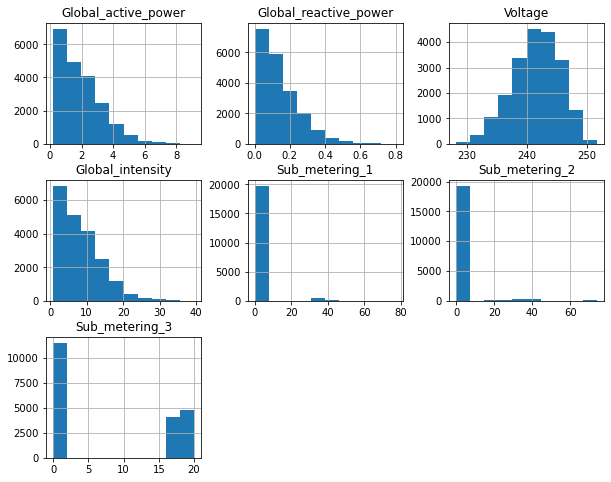

In [14]:
df_1.hist(figsize=(10,8), bins=10)
plt.show()

In [15]:
# Data Correlation
correlation = df_1.corr()
correlation

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Global_active_power,1.000000,0.223530,-0.647289,0.998655,0.387026,0.384222,0.535812
Global_reactive_power,0.223530,1.000000,-0.147997,0.233278,0.075719,0.125012,0.079339
Voltage,-0.647289,-0.147997,1.000000,-0.653697,-0.223929,-0.222241,-0.488880
Global_intensity,0.998655,0.233278,-0.653697,1.000000,0.390884,0.389506,0.527737
Sub_metering_1,0.387026,0.075719,-0.223929,0.390884,1.000000,0.052024,0.084996
Sub_metering_2,0.384222,0.125012,-0.222241,0.389506,0.052024,1.000000,0.049669
Sub_metering_3,0.535812,0.079339,-0.488880,0.527737,0.084996,0.049669,1.000000


<AxesSubplot:>

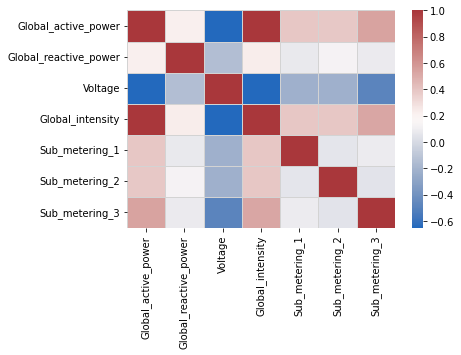

In [16]:
cmap = sns.color_palette("vlag", as_cmap=True)

sns.heatmap(correlation, cmap = cmap, linewidths= 1, linecolor='lightgray')

In [17]:
df_2 = df_1.copy()
df_2 = df_2.drop(['Date', 'Time'], axis = 1)

In [18]:
# Reducing dimension of the dataframe
pca = PCA(n_components=2).fit_transform(df_2)
pca

array([[12.10377363, -6.89055793],
       [14.15578251, -6.44530152],
       [15.35204155, -6.21075036],
       ...,
       [-9.78373038,  2.57086904],
       [-9.69111505,  2.54803062],
       [-9.41808484,  2.48073753]])

In [19]:
# Creating DBSCAN Model to understand how mony labels we have into the data
dbscan_v1 = DBSCAN(eps = 0.8, metric = 'euclidean')
dbscan_v1.fit(pca)

DBSCAN(eps=0.8)

In [20]:
print(np.unique(dbscan_v1.labels_))

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23]


Now we have 24 labels and noises.

In this case, We can create a KMeans predictor for each K number and evaluate each performance.

### K-Means Elbow Method using Inertia

In [27]:
# Creating K-Means Model

k_values = range(1,24)

metrics = []

for K in k_values:
    
    kmeans_ = KMeans(n_clusters= K).fit(pca)
    metrics.append(kmeans_.inertia_)

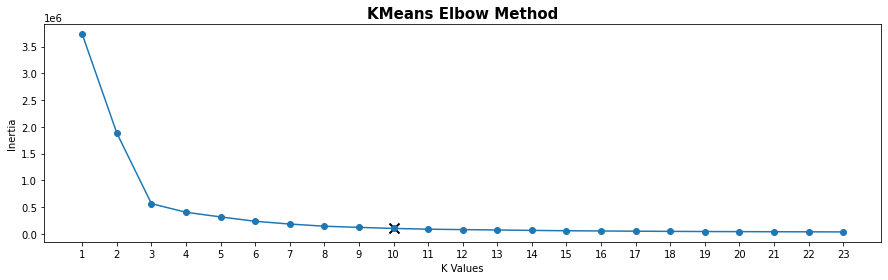

In [31]:
plt.plot(k_values, metrics, 'o-')
plt.xticks(k_values)
plt.xlabel("K Values")
plt.ylabel("Inertia")
plt.title("KMeans Elbow Method", size = 15, fontweight = 'bold')

plt.scatter(10,(0.1*1000000), marker= 'x', c='black', linewidths=2, s = 100)

plt.show()

In [32]:
cluster = 10

kmeans_v1 = KMeans(n_clusters=cluster)
y_pred = kmeans_v1.fit_predict(pca)

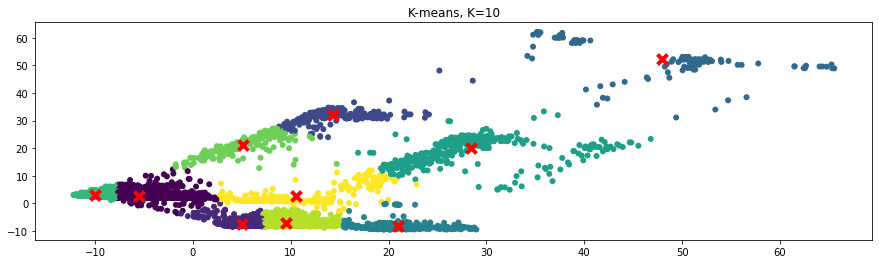

In [33]:
# Criando o classificador e construindo o modelo

plt.title("K-means, K=%s" % cluster)
plt.scatter(pca[:, 0], pca[:, 1], c = y_pred, edgecolors = 'none')
plt.scatter(kmeans_v1.cluster_centers_[:,0], kmeans_v1.cluster_centers_[:,1], marker = 'x', color = 'r', s = 100, linewidths = 4)

plt.show()

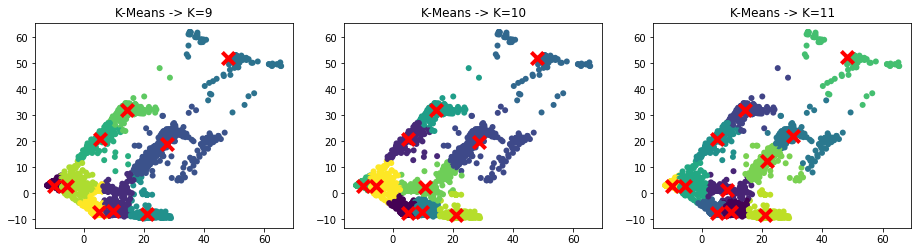

In [41]:
from matplotlib import pylab
pylab.rcParams['figure.figsize'] = (60, 40)

for K in [9 , 10 , 11]:
    
    kmeans_v2 = KMeans(n_clusters= K)
    y_pred = kmeans_v2.fit_predict(pca)
    
    plt.subplot(9, 11, K-1)
    plt.title('K-Means -> K=%d' % K)
    plt.scatter(pca[:,0], pca[:,1], c = y_pred, edgecolors= 'none')
    plt.scatter(kmeans_v2.cluster_centers_[:,0],kmeans_v2.cluster_centers_[:,1], marker = 'x', s = 150, c = 'r', linewidths=4)

The K = 10, represents the elbow turn right before it becomes straight into the KMeans elbow method.

### K-Means Elbow Method using Spacial Distance Calculation

In [57]:
# Creating K-Means Model again - The Same Code as before, just to make it clearer

k_values = range(1,24)

metrics = []

for K in k_values:
    
    kmeans_ = KMeans(n_clusters= K).fit(pca)
    metrics.append(kmeans_)

In [58]:
# Adjusting Centroids of each cluster for each model
centroids = [ i.cluster_centers_ for i in metrics ]

In [59]:
# Calculating euclidean distance from each centroid to suraound data.
k_euclid = [cdist(pca,i, 'euclidean') for i in centroids]
dist = [np.min(i, axis = 1) for i in k_euclid] 

In [60]:
# Summarizing the squared distances into clusters
sum_squared_intra = [sum(d**2) for d in dist]

In [61]:
total_sum = sum(pdist(pca)**2)/pca.shape[0]

In [62]:
sum_squared_inter = total_sum - sum_squared_intra

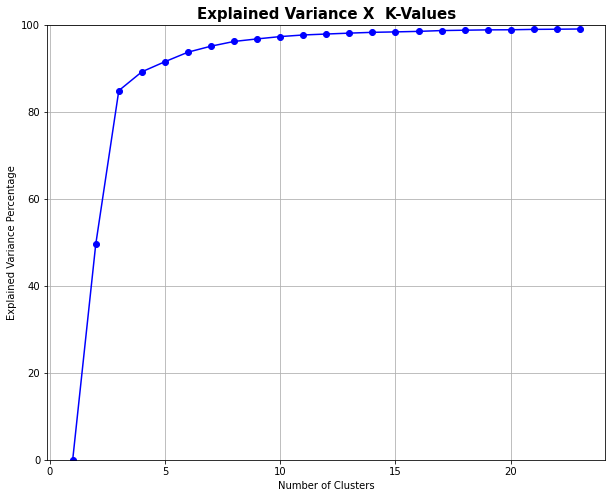

In [80]:
# Elbow Curve

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.plot(k_values, sum_squared_inter/total_sum *100, 'bo-')
ax.set_ylim(0,100)
plt.grid(True)
plt.xlabel("Number of Clusters")
plt.ylabel("Explained Variance Percentage")
plt.title("Explained Variance X  K-Values", fontweight = 'bold', size = 15)
plt.show()

In this case, this elbow curve indicates that values above 10 are flattening onto the data, so that, the minimum value to be considered is around 10.

Let's create a silhouette score to make sure that we've selected the best K value.

### Silhouettte Score

In [65]:
?silhouette_score

The Silhouette Coefficient is calculated using the mean intra-cluster
distance (``a``) and the mean nearest-cluster distance (``b``) for each
sample.  The Silhouette Coefficient for a sample is ``(b - a) / max(a,
b)``.

In [66]:
# Using original model -> kmeans_v1   K=10

labels =kmeans_v1.labels_
silhouette_score(pca, labels, metric='euclidean')

0.604777361099595

Considering the silhouette score presented above, I'm going to use a range of K values where the elbow curve start to platten until it gets flattened.

In [76]:
k_values1 = range(8,14)

silhouette_score_values = []

for K in k_values1:
    
    kmeans_ = KMeans(n_clusters= K).fit(pca)
    labels = kmeans_.labels_
    x = silhouette_score(pca, labels, metric = 'euclidean')
    silhouette_score_values.append(x)

In [77]:
silhouette_score_values

[0.5885101296977013,
 0.5909566187614191,
 0.6048093757257098,
 0.606300634973679,
 0.5792508816987507,
 0.5798134918814685]

In [78]:
# Creating last version model using K = 11

k_value = 11

kmeans_v3 = KMeans(n_clusters=k_value)
y_pred_new = kmeans_v3.fit_predict(pca)

According to the tests done above, the best model results were obteined with K=11.

Now I'll place each label created by the best model (kmeans_v3) to the original dataframe

In [81]:
df_2.head(1)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,4.216,0.418,234.84,18.4,0.0,1.0,17.0


In [82]:
col_names = ['Global_active_power','Global_reactive_power','Voltage','Global_intensity','Sub_metering_1','Sub_metering_2','Sub_metering_3']

In [85]:
cluster_map = pd.DataFrame(df_2, columns = col_names)
cluster_map['Clusters'] = kmeans_v3.labels_

In [86]:
cluster_map

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Clusters
0,4.216,0.418,234.84,18.4,0.0,1.0,17.0,7
1,5.360,0.436,233.63,23.0,0.0,1.0,16.0,7
2,5.374,0.498,233.29,23.0,0.0,2.0,17.0,7
3,5.388,0.502,233.74,23.0,0.0,1.0,17.0,7
4,3.666,0.528,235.68,15.8,0.0,1.0,17.0,7
...,...,...,...,...,...,...,...,...
20492,0.386,0.250,241.57,1.8,0.0,0.0,0.0,4
20493,0.386,0.256,242.60,1.8,0.0,0.0,0.0,4
20494,0.386,0.258,242.91,1.8,0.0,0.0,0.0,4
20495,0.382,0.258,242.54,1.8,0.0,0.0,0.0,4


#### Calculate de average energy consumption by each Cluster or 'customer group'

In [88]:
avg_customer = cluster_map.groupby("Clusters")['Global_active_power'].mean()

In [89]:
avg_customer

Clusters
0     1.780305
1     2.097296
2     3.308272
3     4.964405
4     0.435178
5     6.489009
6     3.777287
7     3.490040
8     4.633167
9     2.110383
10    3.996144
Name: Global_active_power, dtype: float64

For the future, it can be done an Regression algorithm to predict consumption values by groups or vice versa.